# DECISION TREE REGRESSION


**Weighted MSE for a Split**

The weighted MSE for a split is calculated as:

$
\text{Weighted MSE} = \frac{N_{left}}{N} \cdot MSE(left) + \frac{N_{right}}{N} \cdot MSE(right)
$

Where:
- $N$ is the total number of samples before the split.
- $N_{left}$ is the number of samples in the left child node after the split.
- $N_{right}$ is the number of samples in the right child node after the split.
- $MSE(left)$ and $MSE(right)$ are the Mean Squared Errors for the left and right child nodes, respectively.


In [322]:
# IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.base import BaseEstimator, RegressorMixin

In [323]:
# CREATE DATA
X, y = make_regression(n_samples=1_000, n_features=1, noise=10, random_state=42)
y = y + 60

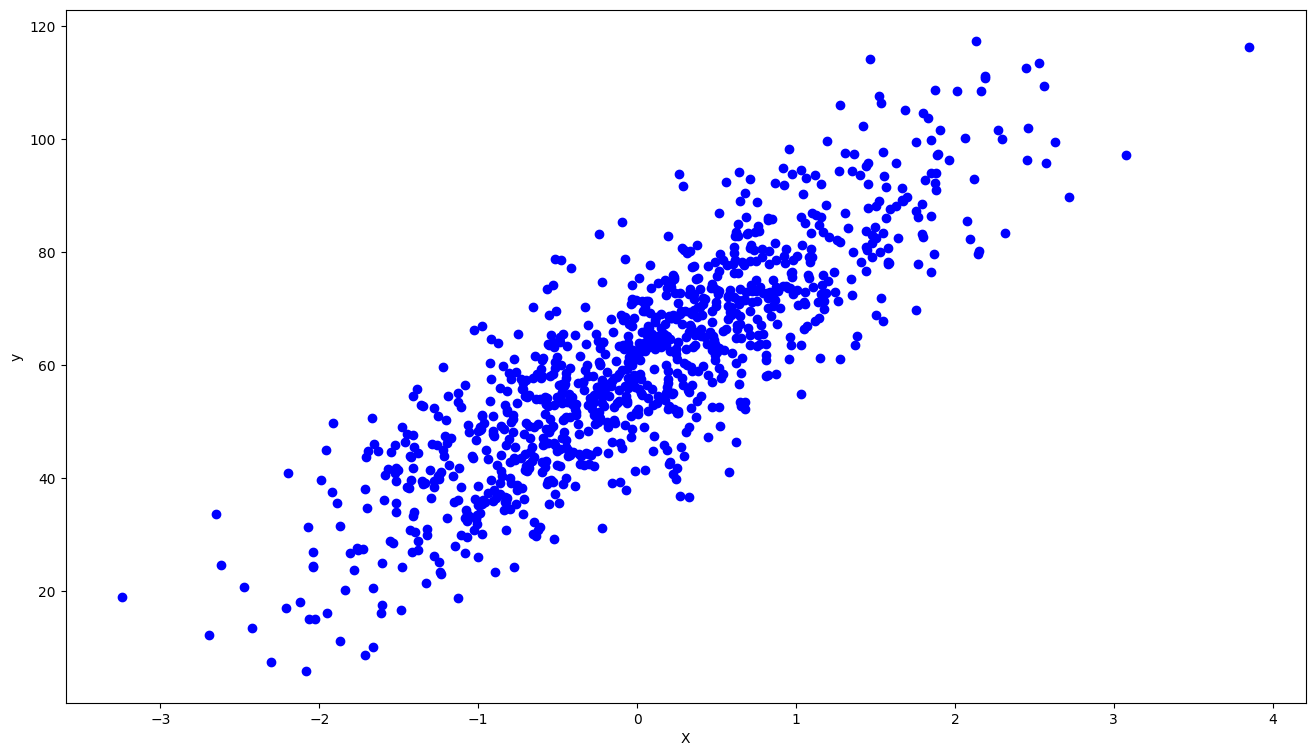

In [324]:
# PLOT DATA
plt.figure(figsize=(16, 9))
plt.plot(X, y, 'bo')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [325]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [326]:

# HOW IT WORKS IN MY OWN WORDS:
# (I got the explanation in detail in notebook decision_tree_classification.ipynb)
# The system is mostly the same as in classification, but the difference is that we are trying to predict a value.
# The predicted value is the mean of the certain portion of the dataset. The algorithm tries to find the best split
# during checking all thresholds. The score for each split is calculated by combining the weighted mean squared errors
# from both sides of the split. The algorithm tries to find the smallest weighted mean squared error.


# DECISION TREE REGRESSION

class MyDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, min_samples_split: int = 2, max_depth: int = 10):
        """
        Initialize the MyDecisionTreeRegressor with specified parameters.

        :param min_samples_split: The minimum number of samples required to split an internal node.
        :param max_depth: The maximum depth of the tree.
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree: 'MyDecisionTreeRegressor.Node' = None

    class Node:
        """
        A class representing a single node in the decision tree.

        :param feature_column_index: The index of the feature column used for splitting at this node.
        :param threshold: The threshold value used to split the feature at this node.
        :param left: The left child node.
        :param right: The right child node.
        :param value: The predicted value if the node is a leaf, otherwise None.
        """

        def __init__(self,
                     feature_column_index: int = None,
                     threshold: float = None,
                     left: 'MyDecisionTreeRegressor.Node' = None,
                     right: 'MyDecisionTreeRegressor.Node' = None,
                     value: float = None):
            self.feature_column_index = feature_column_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the decision tree regressor on the training data.

        :param X: The training input samples.
        :param y: The target values (continuous values).
        :return: Fitted estimator.
        """
        self.tree = self._grow_tree(X, y)
        return self

    def predict(self, X: np.ndarray):
        """
        Predict values for samples in X.

        :param X: The input samples.
        :return: The predicted values.
        """
        return np.array([self._predict_input(x, self.tree) for x in X])

    def _grow_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0):
        """
        Recursively grow the decision tree.

        :param X: The input samples.
        :param y: The target values (continuous values).
        :param depth: The current depth of the tree.
        :return: The root node of the decision tree.
        """
        nr_samples, nr_features = X.shape

        # Stopping conditions
        if (depth >= self.max_depth
                or nr_samples < self.min_samples_split):
            value = np.mean(y)
            return self.Node(value=value)

        # Find the best split
        best_mse = float('inf')
        best_feature_column_index = None
        best_threshold = None

        for feature_column_index in range(nr_features):
            feature_column = X[:, feature_column_index]
            thresholds = np.unique(feature_column)
            for threshold in thresholds:
                mse = self._calculate_weighted_mse(feature_column, y, threshold)
                if mse < best_mse:
                    best_mse = mse
                    best_feature_column_index = feature_column_index
                    best_threshold = threshold

        if best_mse == float('inf'):
            value = np.mean(y)
            return self.Node(value=value)

        # Grow the children
        left_indices = X[:, best_feature_column_index] <= best_threshold
        right_indices = X[:, best_feature_column_index] > best_threshold
        left_subtree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        return self.Node(best_feature_column_index, best_threshold,
                         left_subtree, right_subtree)

    def _calculate_weighted_mse(self, feature_column: np.ndarray, y: np.ndarray, threshold: float):
        """
        Calculate the weighted mean squared error (MSE) for a potential split.

        :param feature_column: The feature values for the samples.
        :param y: The target values (continuous values).
        :param threshold: The threshold value to split the feature.
        :return: The weighted mean squared error for the split.
        """
        left_indices = feature_column <= threshold
        right_indices = feature_column > threshold

        if len(left_indices) == 0 or len(right_indices) == 0:
            return float('inf')

        left_mse = self._calculate_mse(y[left_indices])
        right_mse = self._calculate_mse(y[right_indices])
        left_weight = len(y[left_indices]) / len(y)
        right_weight = len(y[right_indices]) / len(y)
        return left_weight * left_mse + right_weight * right_mse

    def _calculate_mse(self, y: np.ndarray):
        """
        Calculate the mean squared error (MSE) for a set of values.

        :param y: The target values (continuous values).
        :return: The mean squared error.
        """
        if len(y) == 0:
            return float('inf')
        mean = np.mean(y)
        mse = np.mean((y - mean) ** 2)
        return mse

    def _predict_input(self, x: np.ndarray, node: 'MyDecisionTreeRegressor.Node'):
        """
        Predict the value for a single input using the trained tree.

        :param x: The input sample.
        :param node: The current node in the decision tree.
        :return: The predicted value for the input sample.
        """
        if node.value is not None:
            return node.value
        if x[node.feature_column_index] <= node.threshold:
            return self._predict_input(x, node.left)
        return self._predict_input(x, node.right)


In [327]:
# TRAIN MODEL
dc_reg = MyDecisionTreeRegressor(max_depth=4)
dc_reg.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=4)

In [328]:
# PREDICT
y_pred = dc_reg.predict(X_test)

In [329]:
# CROSS VALIDATION
cv_results = cross_validate(dc_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_results['test_score']

array([ -99.87329351, -101.61486054,  -92.19255075, -119.78046305,
       -103.34688771])

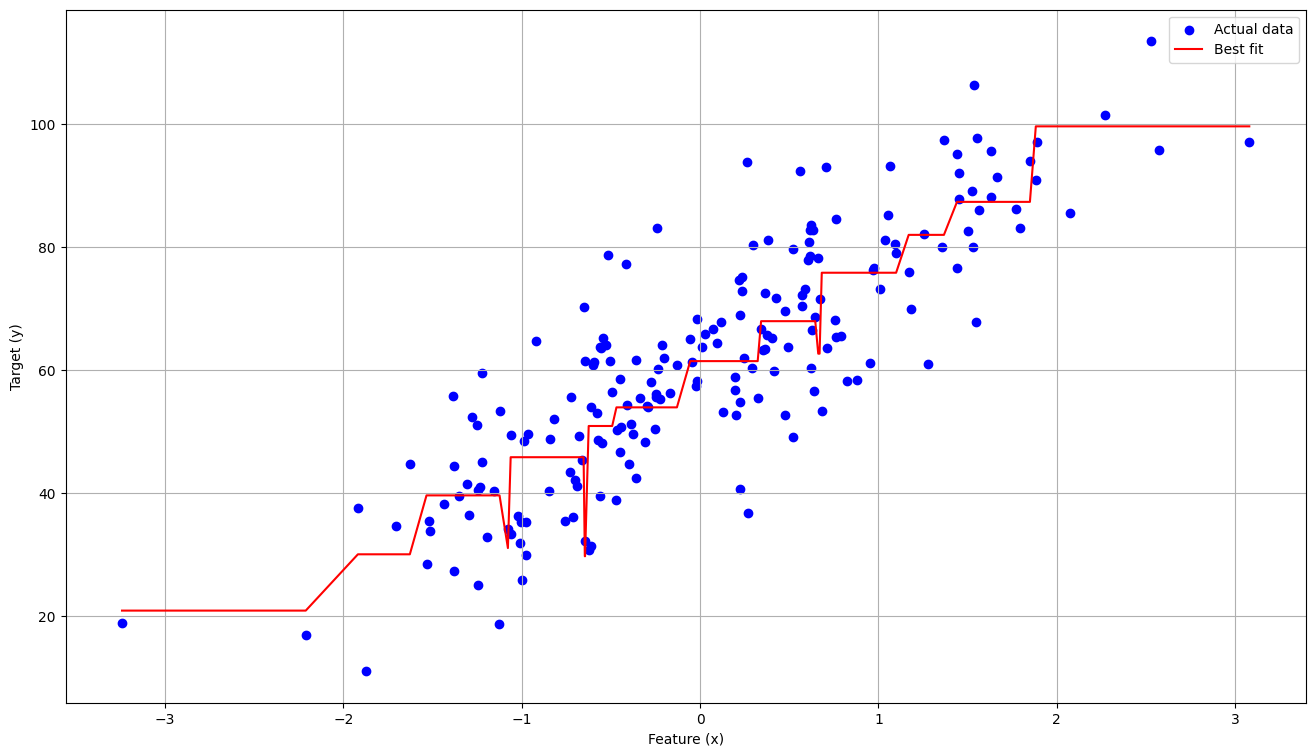

In [330]:
# Sort the data based on the feature to maintain the relationship
sort_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test[sort_indices]
y_test_sorted = y_test[sort_indices]
y_pred_sorted = y_pred[sort_indices]

# Plot the data
fig = plt.figure(figsize=(16, 9))
plt.scatter(X_test_sorted, y_test_sorted, label="Actual data", color='b')
plt.plot(X_test_sorted, y_pred_sorted, label="Best fit", color='r')
plt.xlabel('Feature (x)')
plt.ylabel('Target (y)')
plt.legend()
plt.grid()
plt.show()

In [331]:
dec_reg2 = MyDecisionTreeRegressor(max_depth=1)

In [332]:
y_pred2 = dec_reg2.fit(X_train, y_train).predict(X_test)

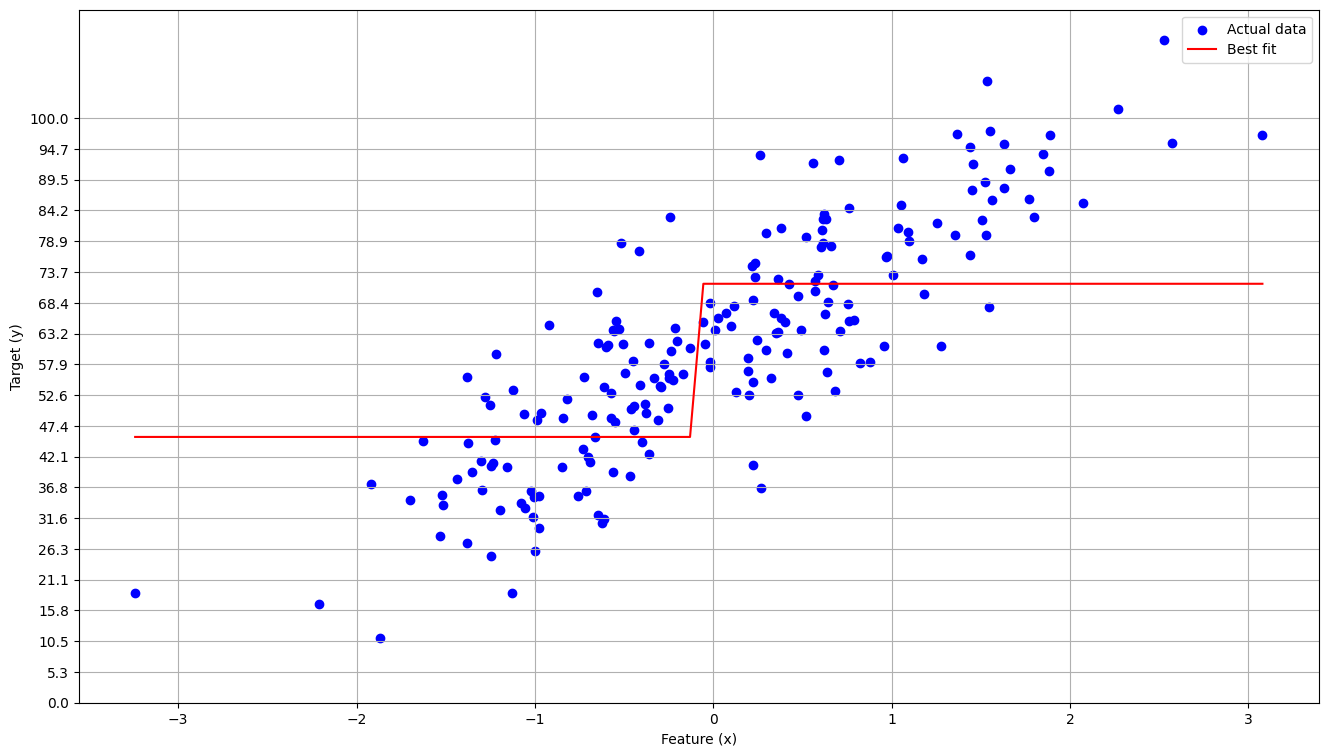

In [333]:
sort_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test[sort_indices]
y_test_sorted = y_test[sort_indices]
y_pred_sorted = y_pred2[sort_indices]

# Plot the data
plt.figure(figsize=(16, 9))
plt.scatter(X_test_sorted, y_test_sorted, label="Actual data", color='b')
plt.plot(X_test_sorted, y_pred_sorted, label="Best fit", color='r')
plt.xlabel('Feature (x)')
plt.ylabel('Target (y)')
plt.yticks(np.linspace(0, 100, 20))
plt.legend()
plt.grid()

In [334]:

# Just an experimental example of average values of some sort.
print((105 + 36.8) / 2)  # The right side of the tree
print((84 + 10.5) / 2)  # The left side of the tree

# If we just tried to make a solid line across whole dataset mean we would get:
print(np.mean(y_train))

# The algorithm tries to find the best split based on computation of scores from both sides of the split.

70.9
47.25
60.17002244893469
